In [ ]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Importing necessary libraries


In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from tqdm import tqdm

## Preparing training and validation data

This prepares file paths for training and validation data by locating NIFTI image and label files for spleen segmentation.

It creates a list of dictionaries, each containing an image file path and its corresponding label file path, and then splits them into training and validation sets.





In [ ]:
data_dir = os.path.join("/content/drive/Spleen-Segmentation/Data/Task09_Spleen")
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [ ]:
set_determinism(seed=0)

# Monai Transforms

- This utilizes different Monai transforms for both training and validation data in medical image analysis.

- The transforms include loading images and labels, ensuring channel-first format, adjusting intensity range, cropping out empty space, orienting the images, adjusting spacing, and performing random cropping based on positive and negative labels for training.

- Validation transforms exclude the random cropping for a consistent evaluation.

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

# Check transforms in DataLoader

This loads a validation dataset, processes the first batch, extracts an image and its corresponding label, and displays a specific slice (at index 80) from both the image and label for visual inspection in a side-by-side plot.

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


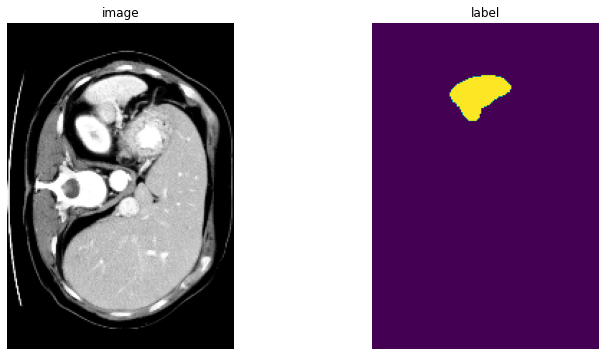

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)

check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.axis("off")
plt.show()

# Visualzing Intermediate Preprocessing Outputs

It is important to analyze how the intermediate outputs look like.

- This demonstrates various data processing steps for a single validation image.

- It loads, scales pixel intensities, ensures channel-first format, performs intensity scaling, and then crops out the foreground region of the image.

- Intermediate results and histograms are visualized to illustrate the transformations and data characteristics.

torch.Size([512, 512, 50])


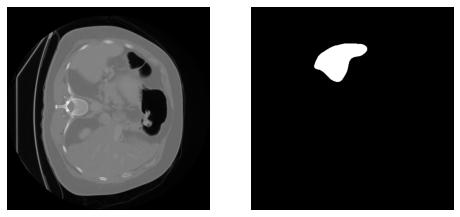

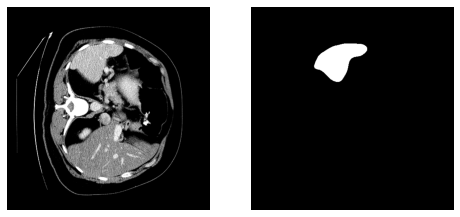

torch.Size([1, 512, 512, 50])


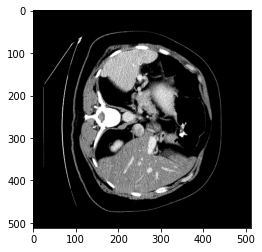

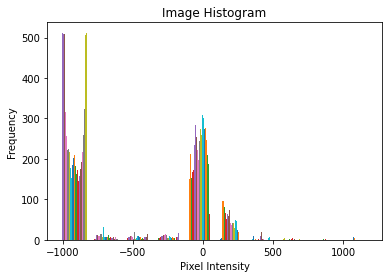

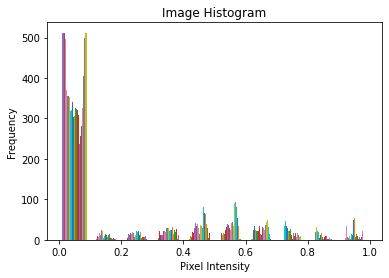

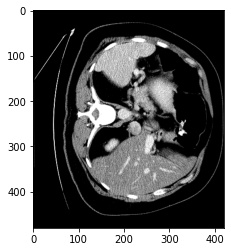

In [ ]:
import numpy as np

# Loading image and label
result1 = LoadImaged(keys=["image", "label"])(val_files[1])
print(result1["image"].shape)
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.imshow(result1["image"][:,:,30], cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(result1["label"][:,:,30], cmap="gray")
plt.axis("off")
plt.show()

# Scaling Pixel Intensity
result2 = EnsureChannelFirstd(keys=["image", "label"])(result1)
# print(np.max(result2["image"][0,:,:,30]))
result = ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        )(result2)
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.imshow(result["image"][0,:,:,30], cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(result["label"][0,:,:,30], cmap="gray")
plt.axis("off")
plt.show()

# print(np.min(result["image"][0]))
print(result["label"].shape)
plt.imshow(result["image"][0,:,:,30], cmap="gray")

plt.show()
plt.hist(result1["image"][:,:,30])
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Image Histogram")
plt.show()
plt.hist(result["image"][0,:,:,30])
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Image Histogram")
plt.show()

cropped = CropForegroundd(keys=["image", "label"], source_key="image")(result)
plt.imshow(cropped["image"][0,:,:,30], cmap="gray")


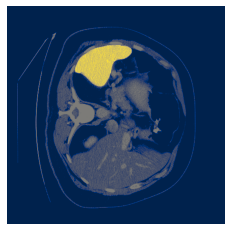

In [ ]:
# Overlaying mask over image
plt.imshow(result["image"][0,:,:,30]+result["label"][0,:,:,30], cmap="cividis")
plt.axis("off")
plt.show()

# Define CacheDataset and DataLoader for training and validation


In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

# Create Model

- This defines a 3D U-Net model for semantic segmentation, utilizing GPU if available.

- The model architecture consists of contracting and expanding paths with specified channels and strides, enhanced by residual units.

- The training setup includes the Dice loss, Adam optimizer, and a Dice metric for evaluation, targeting multi-class segmentation with background excluded.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Training Loop

This trains a U-Net model for semantic segmentation over multiple epochs, evaluating on a validation dataset at intervals.

It tracks loss, dice metric, and saves checkpoints of the model's state, optimizer state, and training progress to monitor and resume training later.

In [ ]:
max_epochs = 500
val_interval = 2
checkpoint = torch.load("/content/drive/Spleen-Segmentation/ImprovedResults/my_checkpoint.pth.tar")
best_metric = checkpoint["best_metric"]
best_metric_epoch = checkpoint["best_metric_epoch"]
epoch_loss_values = checkpoint["train_loss"]
metric_values = checkpoint["val_dice"]
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
save_dir = "/content/drive/Spleen-Segmentation/ImprovedResults"
checkpoint = {}

for epoch in range(240, max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in tqdm(train_loader):
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(
        #     f"{step}/{len(train_ds) // train_loader.batch_size}, "
        #     f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    save_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
    checkpoint["train_loss"] = epoch_loss_values
    checkpoint["val_dice"] = metric_values
    checkpoint["best_metric_epoch"] = best_metric_epoch
    checkpoint["best_metric"] = best_metric
    checkpoint["model_state_dict"] = model.state_dict()
    checkpoint["optimizer_state_dict"] = optimizer.state_dict()
    torch.save(checkpoint, os.path.join(save_dir, "my_checkpoint2.pth.tar"))




----------
epoch 241/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 241 average loss: 0.1909
----------
epoch 242/500


100%|██████████| 16/16 [00:16<00:00,  1.01s/it]

epoch 242 average loss: 0.1937



/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


current epoch: 242 current mean dice: 0.9361
best mean dice: 0.9448 at epoch: 236
----------
epoch 243/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 243 average loss: 0.1607
----------
epoch 244/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 244 average loss: 0.1744


current epoch: 244 current mean dice: 0.9389
best mean dice: 0.9448 at epoch: 236
----------
epoch 245/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 245 average loss: 0.1827
----------
epoch 246/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 246 average loss: 0.2138


current epoch: 246 current mean dice: 0.7131
best mean dice: 0.9448 at epoch: 236
----------
epoch 247/500


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


epoch 247 average loss: 0.1929
----------
epoch 248/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

epoch 248 average loss: 0.2201


current epoch: 248 current mean dice: 0.8710
best mean dice: 0.9448 at epoch: 236
----------
epoch 249/500


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


epoch 249 average loss: 0.1908
----------
epoch 250/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 250 average loss: 0.1753


current epoch: 250 current mean dice: 0.6942
best mean dice: 0.9448 at epoch: 236
----------
epoch 251/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 251 average loss: 0.1773
----------
epoch 252/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 252 average loss: 0.1954


current epoch: 252 current mean dice: 0.8481
best mean dice: 0.9448 at epoch: 236
----------
epoch 253/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 253 average loss: 0.1765
----------
epoch 254/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 254 average loss: 0.1794


current epoch: 254 current mean dice: 0.9340
best mean dice: 0.9448 at epoch: 236
----------
epoch 255/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 255 average loss: 0.1968
----------
epoch 256/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 256 average loss: 0.1860


current epoch: 256 current mean dice: 0.3950
best mean dice: 0.9448 at epoch: 236
----------
epoch 257/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 257 average loss: 0.1861
----------
epoch 258/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 258 average loss: 0.2045


current epoch: 258 current mean dice: 0.9414
best mean dice: 0.9448 at epoch: 236
----------
epoch 259/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 259 average loss: 0.2331
----------
epoch 260/500


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]

epoch 260 average loss: 0.1867


current epoch: 260 current mean dice: 0.8555
best mean dice: 0.9448 at epoch: 236
----------
epoch 261/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 261 average loss: 0.1799
----------
epoch 262/500


100%|██████████| 16/16 [00:15<00:00,  1.03it/s]

epoch 262 average loss: 0.1905


current epoch: 262 current mean dice: 0.9329
best mean dice: 0.9448 at epoch: 236
----------
epoch 263/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 263 average loss: 0.1931
----------
epoch 264/500


100%|██████████| 16/16 [00:15<00:00,  1.07it/s]

epoch 264 average loss: 0.1745


current epoch: 264 current mean dice: 0.9393
best mean dice: 0.9448 at epoch: 236
----------
epoch 265/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 265 average loss: 0.1931
----------
epoch 266/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 266 average loss: 0.1778


current epoch: 266 current mean dice: 0.9405
best mean dice: 0.9448 at epoch: 236
----------
epoch 267/500


100%|██████████| 16/16 [00:15<00:00,  1.07it/s]


epoch 267 average loss: 0.1846
----------
epoch 268/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 268 average loss: 0.2141


current epoch: 268 current mean dice: 0.9433
best mean dice: 0.9448 at epoch: 236
----------
epoch 269/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 269 average loss: 0.1944
----------
epoch 270/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 270 average loss: 0.2129


current epoch: 270 current mean dice: 0.9284
best mean dice: 0.9448 at epoch: 236
----------
epoch 271/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 271 average loss: 0.1981
----------
epoch 272/500


100%|██████████| 16/16 [00:15<00:00,  1.00it/s]

epoch 272 average loss: 0.1955


current epoch: 272 current mean dice: 0.8927
best mean dice: 0.9448 at epoch: 236
----------
epoch 273/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 273 average loss: 0.2041
----------
epoch 274/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 274 average loss: 0.1612


saved new best metric model
current epoch: 274 current mean dice: 0.9469
best mean dice: 0.9469 at epoch: 274
----------
epoch 275/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 275 average loss: 0.1694
----------
epoch 276/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 276 average loss: 0.1901


current epoch: 276 current mean dice: 0.9397
best mean dice: 0.9469 at epoch: 274
----------
epoch 277/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 277 average loss: 0.1664
----------
epoch 278/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 278 average loss: 0.1900


current epoch: 278 current mean dice: 0.9261
best mean dice: 0.9469 at epoch: 274
----------
epoch 279/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 279 average loss: 0.1884
----------
epoch 280/500


100%|██████████| 16/16 [00:15<00:00,  1.07it/s]

epoch 280 average loss: 0.1795


current epoch: 280 current mean dice: 0.9439
best mean dice: 0.9469 at epoch: 274
----------
epoch 281/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


epoch 281 average loss: 0.1541
----------
epoch 282/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]

epoch 282 average loss: 0.1811


current epoch: 282 current mean dice: 0.9379
best mean dice: 0.9469 at epoch: 274
----------
epoch 283/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 283 average loss: 0.1849
----------
epoch 284/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 284 average loss: 0.1911


current epoch: 284 current mean dice: 0.6667
best mean dice: 0.9469 at epoch: 274
----------
epoch 285/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 285 average loss: 0.1290
----------
epoch 286/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 286 average loss: 0.1893


current epoch: 286 current mean dice: 0.9107
best mean dice: 0.9469 at epoch: 274
----------
epoch 287/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


epoch 287 average loss: 0.1818
----------
epoch 288/500


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]

epoch 288 average loss: 0.2150


current epoch: 288 current mean dice: 0.9153
best mean dice: 0.9469 at epoch: 274
----------
epoch 289/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 289 average loss: 0.1659
----------
epoch 290/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 290 average loss: 0.1855


current epoch: 290 current mean dice: 0.9446
best mean dice: 0.9469 at epoch: 274
----------
epoch 291/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 291 average loss: 0.1935
----------
epoch 292/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 292 average loss: 0.2407


current epoch: 292 current mean dice: 0.8316
best mean dice: 0.9469 at epoch: 274
----------
epoch 293/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 293 average loss: 0.1472
----------
epoch 294/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 294 average loss: 0.1988


current epoch: 294 current mean dice: 0.9291
best mean dice: 0.9469 at epoch: 274
----------
epoch 295/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 295 average loss: 0.2116
----------
epoch 296/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]

epoch 296 average loss: 0.1820


current epoch: 296 current mean dice: 0.9219
best mean dice: 0.9469 at epoch: 274
----------
epoch 297/500


100%|██████████| 16/16 [00:16<00:00,  1.02s/it]


epoch 297 average loss: 0.1652
----------
epoch 298/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 298 average loss: 0.1858


current epoch: 298 current mean dice: 0.9384
best mean dice: 0.9469 at epoch: 274
----------
epoch 299/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 299 average loss: 0.2170
----------
epoch 300/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 300 average loss: 0.1966


current epoch: 300 current mean dice: 0.9403
best mean dice: 0.9469 at epoch: 274
----------
epoch 301/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 301 average loss: 0.1451
----------
epoch 302/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 302 average loss: 0.1855


current epoch: 302 current mean dice: 0.9382
best mean dice: 0.9469 at epoch: 274
----------
epoch 303/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


epoch 303 average loss: 0.2170
----------
epoch 304/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 304 average loss: 0.2060


current epoch: 304 current mean dice: 0.7250
best mean dice: 0.9469 at epoch: 274
----------
epoch 305/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 305 average loss: 0.1911
----------
epoch 306/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 306 average loss: 0.1492


current epoch: 306 current mean dice: 0.9361
best mean dice: 0.9469 at epoch: 274
----------
epoch 307/500


100%|██████████| 16/16 [00:15<00:00,  1.07it/s]


epoch 307 average loss: 0.1746
----------
epoch 308/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 308 average loss: 0.2001


current epoch: 308 current mean dice: 0.9412
best mean dice: 0.9469 at epoch: 274
----------
epoch 309/500


100%|██████████| 16/16 [00:15<00:00,  1.00it/s]


epoch 309 average loss: 0.2005
----------
epoch 310/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

epoch 310 average loss: 0.1568


current epoch: 310 current mean dice: 0.9363
best mean dice: 0.9469 at epoch: 274
----------
epoch 311/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 311 average loss: 0.1823
----------
epoch 312/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 312 average loss: 0.1976


current epoch: 312 current mean dice: 0.9345
best mean dice: 0.9469 at epoch: 274
----------
epoch 313/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 313 average loss: 0.2101
----------
epoch 314/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 314 average loss: 0.1902


current epoch: 314 current mean dice: 0.9408
best mean dice: 0.9469 at epoch: 274
----------
epoch 315/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 315 average loss: 0.2136
----------
epoch 316/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 316 average loss: 0.2098


current epoch: 316 current mean dice: 0.9368
best mean dice: 0.9469 at epoch: 274
----------
epoch 317/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


epoch 317 average loss: 0.2140
----------
epoch 318/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 318 average loss: 0.1628


current epoch: 318 current mean dice: 0.9449
best mean dice: 0.9469 at epoch: 274
----------
epoch 319/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 319 average loss: 0.1869
----------
epoch 320/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 320 average loss: 0.1876


current epoch: 320 current mean dice: 0.9464
best mean dice: 0.9469 at epoch: 274
----------
epoch 321/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 321 average loss: 0.1529
----------
epoch 322/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

epoch 322 average loss: 0.2098


current epoch: 322 current mean dice: 0.9463
best mean dice: 0.9469 at epoch: 274
----------
epoch 323/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 323 average loss: 0.1784
----------
epoch 324/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 324 average loss: 0.1761


current epoch: 324 current mean dice: 0.9371
best mean dice: 0.9469 at epoch: 274
----------
epoch 325/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 325 average loss: 0.2176
----------
epoch 326/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 326 average loss: 0.1707


current epoch: 326 current mean dice: 0.9357
best mean dice: 0.9469 at epoch: 274
----------
epoch 327/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 327 average loss: 0.2063
----------
epoch 328/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 328 average loss: 0.1700


current epoch: 328 current mean dice: 0.8365
best mean dice: 0.9469 at epoch: 274
----------
epoch 329/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 329 average loss: 0.1712
----------
epoch 330/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

epoch 330 average loss: 0.1693


current epoch: 330 current mean dice: 0.8528
best mean dice: 0.9469 at epoch: 274
----------
epoch 331/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 331 average loss: 0.1484
----------
epoch 332/500


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]

epoch 332 average loss: 0.1726


current epoch: 332 current mean dice: 0.9431
best mean dice: 0.9469 at epoch: 274
----------
epoch 333/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 333 average loss: 0.1763
----------
epoch 334/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 334 average loss: 0.1589


current epoch: 334 current mean dice: 0.9401
best mean dice: 0.9469 at epoch: 274
----------
epoch 335/500


100%|██████████| 16/16 [00:16<00:00,  1.01s/it]


epoch 335 average loss: 0.1956
----------
epoch 336/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 336 average loss: 0.1724


current epoch: 336 current mean dice: 0.9386
best mean dice: 0.9469 at epoch: 274
----------
epoch 337/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 337 average loss: 0.1393
----------
epoch 338/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

epoch 338 average loss: 0.2038


current epoch: 338 current mean dice: 0.8823
best mean dice: 0.9469 at epoch: 274
----------
epoch 339/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 339 average loss: 0.1919
----------
epoch 340/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 340 average loss: 0.1967


current epoch: 340 current mean dice: 0.8162
best mean dice: 0.9469 at epoch: 274
----------
epoch 341/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 341 average loss: 0.1765
----------
epoch 342/500


100%|██████████| 16/16 [00:15<00:00,  1.07it/s]

epoch 342 average loss: 0.1808


current epoch: 342 current mean dice: 0.8909
best mean dice: 0.9469 at epoch: 274
----------
epoch 343/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 343 average loss: 0.1957
----------
epoch 344/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 344 average loss: 0.2165


current epoch: 344 current mean dice: 0.9245
best mean dice: 0.9469 at epoch: 274
----------
epoch 345/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


epoch 345 average loss: 0.1934
----------
epoch 346/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]

epoch 346 average loss: 0.1579


current epoch: 346 current mean dice: 0.9173
best mean dice: 0.9469 at epoch: 274
----------
epoch 347/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 347 average loss: 0.1856
----------
epoch 348/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 348 average loss: 0.1658


current epoch: 348 current mean dice: 0.9444
best mean dice: 0.9469 at epoch: 274
----------
epoch 349/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


epoch 349 average loss: 0.1157
----------
epoch 350/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 350 average loss: 0.1565


current epoch: 350 current mean dice: 0.9383
best mean dice: 0.9469 at epoch: 274
----------
epoch 351/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 351 average loss: 0.1508
----------
epoch 352/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 352 average loss: 0.1717


current epoch: 352 current mean dice: 0.9404
best mean dice: 0.9469 at epoch: 274
----------
epoch 353/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 353 average loss: 0.2209
----------
epoch 354/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

epoch 354 average loss: 0.1612


current epoch: 354 current mean dice: 0.9388
best mean dice: 0.9469 at epoch: 274
----------
epoch 355/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


epoch 355 average loss: 0.1410
----------
epoch 356/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 356 average loss: 0.1940


current epoch: 356 current mean dice: 0.9468
best mean dice: 0.9469 at epoch: 274
----------
epoch 357/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 357 average loss: 0.1739
----------
epoch 358/500


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]

epoch 358 average loss: 0.2015


current epoch: 358 current mean dice: 0.9465
best mean dice: 0.9469 at epoch: 274
----------
epoch 359/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 359 average loss: 0.1833
----------
epoch 360/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 360 average loss: 0.1373


saved new best metric model
current epoch: 360 current mean dice: 0.9494
best mean dice: 0.9494 at epoch: 360
----------
epoch 361/500


100%|██████████| 16/16 [00:16<00:00,  1.02s/it]


epoch 361 average loss: 0.1764
----------
epoch 362/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 362 average loss: 0.1710


current epoch: 362 current mean dice: 0.9406
best mean dice: 0.9494 at epoch: 360
----------
epoch 363/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 363 average loss: 0.1571
----------
epoch 364/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 364 average loss: 0.2110


current epoch: 364 current mean dice: 0.9298
best mean dice: 0.9494 at epoch: 360
----------
epoch 365/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 365 average loss: 0.1620
----------
epoch 366/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 366 average loss: 0.1770


current epoch: 366 current mean dice: 0.9438
best mean dice: 0.9494 at epoch: 360
----------
epoch 367/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 367 average loss: 0.1902
----------
epoch 368/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 368 average loss: 0.2114


current epoch: 368 current mean dice: 0.9469
best mean dice: 0.9494 at epoch: 360
----------
epoch 369/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 369 average loss: 0.1573
----------
epoch 370/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 370 average loss: 0.1945


current epoch: 370 current mean dice: 0.9460
best mean dice: 0.9494 at epoch: 360
----------
epoch 371/500


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


epoch 371 average loss: 0.1875
----------
epoch 372/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 372 average loss: 0.1834


current epoch: 372 current mean dice: 0.9426
best mean dice: 0.9494 at epoch: 360
----------
epoch 373/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 373 average loss: 0.1486
----------
epoch 374/500


100%|██████████| 16/16 [00:15<00:00,  1.07it/s]

epoch 374 average loss: 0.1414


current epoch: 374 current mean dice: 0.9476
best mean dice: 0.9494 at epoch: 360
----------
epoch 375/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 375 average loss: 0.2008
----------
epoch 376/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 376 average loss: 0.1437


current epoch: 376 current mean dice: 0.9451
best mean dice: 0.9494 at epoch: 360
----------
epoch 377/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 377 average loss: 0.1826
----------
epoch 378/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 378 average loss: 0.1977


current epoch: 378 current mean dice: 0.9459
best mean dice: 0.9494 at epoch: 360
----------
epoch 379/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 379 average loss: 0.2190
----------
epoch 380/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 380 average loss: 0.2030


current epoch: 380 current mean dice: 0.9442
best mean dice: 0.9494 at epoch: 360
----------
epoch 381/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 381 average loss: 0.1607
----------
epoch 382/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 382 average loss: 0.1785


current epoch: 382 current mean dice: 0.9435
best mean dice: 0.9494 at epoch: 360
----------
epoch 383/500


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


epoch 383 average loss: 0.2277
----------
epoch 384/500


100%|██████████| 16/16 [00:16<00:00,  1.01s/it]

epoch 384 average loss: 0.1884


current epoch: 384 current mean dice: 0.9492
best mean dice: 0.9494 at epoch: 360
----------
epoch 385/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 385 average loss: 0.1352
----------
epoch 386/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 386 average loss: 0.1772


current epoch: 386 current mean dice: 0.9042
best mean dice: 0.9494 at epoch: 360
----------
epoch 387/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 387 average loss: 0.2087
----------
epoch 388/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 388 average loss: 0.1685


current epoch: 388 current mean dice: 0.9279
best mean dice: 0.9494 at epoch: 360
----------
epoch 389/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 389 average loss: 0.1803
----------
epoch 390/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 390 average loss: 0.1449


current epoch: 390 current mean dice: 0.9466
best mean dice: 0.9494 at epoch: 360
----------
epoch 391/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 391 average loss: 0.2171
----------
epoch 392/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 392 average loss: 0.1678


current epoch: 392 current mean dice: 0.9370
best mean dice: 0.9494 at epoch: 360
----------
epoch 393/500


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


epoch 393 average loss: 0.1652
----------
epoch 394/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 394 average loss: 0.1680


current epoch: 394 current mean dice: 0.8302
best mean dice: 0.9494 at epoch: 360
----------
epoch 395/500


100%|██████████| 16/16 [00:15<00:00,  1.07it/s]


epoch 395 average loss: 0.1828
----------
epoch 396/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 396 average loss: 0.1687


current epoch: 396 current mean dice: 0.9201
best mean dice: 0.9494 at epoch: 360
----------
epoch 397/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 397 average loss: 0.1793
----------
epoch 398/500


100%|██████████| 16/16 [00:15<00:00,  1.07it/s]

epoch 398 average loss: 0.2006


current epoch: 398 current mean dice: 0.7994
best mean dice: 0.9494 at epoch: 360
----------
epoch 399/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 399 average loss: 0.1948
----------
epoch 400/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 400 average loss: 0.1880


current epoch: 400 current mean dice: 0.6611
best mean dice: 0.9494 at epoch: 360
----------
epoch 401/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 401 average loss: 0.1449
----------
epoch 402/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 402 average loss: 0.1975


current epoch: 402 current mean dice: 0.8909
best mean dice: 0.9494 at epoch: 360
----------
epoch 403/500


100%|██████████| 16/16 [00:16<00:00,  1.00s/it]


epoch 403 average loss: 0.1589
----------
epoch 404/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 404 average loss: 0.1756


current epoch: 404 current mean dice: 0.8260
best mean dice: 0.9494 at epoch: 360
----------
epoch 405/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 405 average loss: 0.2008
----------
epoch 406/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 406 average loss: 0.1690


current epoch: 406 current mean dice: 0.6541
best mean dice: 0.9494 at epoch: 360
----------
epoch 407/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 407 average loss: 0.1942
----------
epoch 408/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 408 average loss: 0.1484


current epoch: 408 current mean dice: 0.9424
best mean dice: 0.9494 at epoch: 360
----------
epoch 409/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 409 average loss: 0.1813
----------
epoch 410/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

epoch 410 average loss: 0.2055


current epoch: 410 current mean dice: 0.9390
best mean dice: 0.9494 at epoch: 360
----------
epoch 411/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 411 average loss: 0.1611
----------
epoch 412/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 412 average loss: 0.1602


current epoch: 412 current mean dice: 0.9452
best mean dice: 0.9494 at epoch: 360
----------
epoch 413/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 413 average loss: 0.1578
----------
epoch 414/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 414 average loss: 0.1587


current epoch: 414 current mean dice: 0.8153
best mean dice: 0.9494 at epoch: 360
----------
epoch 415/500


100%|██████████| 16/16 [00:15<00:00,  1.07it/s]


epoch 415 average loss: 0.2084
----------
epoch 416/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 416 average loss: 0.1756


current epoch: 416 current mean dice: 0.7521
best mean dice: 0.9494 at epoch: 360
----------
epoch 417/500


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


epoch 417 average loss: 0.1576
----------
epoch 418/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

epoch 418 average loss: 0.1577


current epoch: 418 current mean dice: 0.9290
best mean dice: 0.9494 at epoch: 360
----------
epoch 419/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 419 average loss: 0.1692
----------
epoch 420/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]

epoch 420 average loss: 0.1824


current epoch: 420 current mean dice: 0.8940
best mean dice: 0.9494 at epoch: 360
----------
epoch 421/500


100%|██████████| 16/16 [00:15<00:00,  1.07it/s]


epoch 421 average loss: 0.1490
----------
epoch 422/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 422 average loss: 0.2080


current epoch: 422 current mean dice: 0.9475
best mean dice: 0.9494 at epoch: 360
----------
epoch 423/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 423 average loss: 0.2177
----------
epoch 424/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

epoch 424 average loss: 0.1791


current epoch: 424 current mean dice: 0.9456
best mean dice: 0.9494 at epoch: 360
----------
epoch 425/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 425 average loss: 0.1685
----------
epoch 426/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 426 average loss: 0.1771


current epoch: 426 current mean dice: 0.9440
best mean dice: 0.9494 at epoch: 360
----------
epoch 427/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 427 average loss: 0.2073
----------
epoch 428/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 428 average loss: 0.1581


saved new best metric model
current epoch: 428 current mean dice: 0.9496
best mean dice: 0.9496 at epoch: 428
----------
epoch 429/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 429 average loss: 0.1410
----------
epoch 430/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 430 average loss: 0.2024


current epoch: 430 current mean dice: 0.9482
best mean dice: 0.9496 at epoch: 428
----------
epoch 431/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 431 average loss: 0.2016
----------
epoch 432/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 432 average loss: 0.1844


current epoch: 432 current mean dice: 0.9494
best mean dice: 0.9496 at epoch: 428
----------
epoch 433/500


100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


epoch 433 average loss: 0.2123
----------
epoch 434/500


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]

epoch 434 average loss: 0.1394


current epoch: 434 current mean dice: 0.8240
best mean dice: 0.9496 at epoch: 428
----------
epoch 435/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 435 average loss: 0.1888
----------
epoch 436/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]

epoch 436 average loss: 0.1920


current epoch: 436 current mean dice: 0.9161
best mean dice: 0.9496 at epoch: 428
----------
epoch 437/500


100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


epoch 437 average loss: 0.1759
----------
epoch 438/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 438 average loss: 0.1894


current epoch: 438 current mean dice: 0.9286
best mean dice: 0.9496 at epoch: 428
----------
epoch 439/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 439 average loss: 0.1646
----------
epoch 440/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 440 average loss: 0.1801


saved new best metric model
current epoch: 440 current mean dice: 0.9498
best mean dice: 0.9498 at epoch: 440
----------
epoch 441/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


epoch 441 average loss: 0.2063
----------
epoch 442/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 442 average loss: 0.1863


current epoch: 442 current mean dice: 0.9376
best mean dice: 0.9498 at epoch: 440
----------
epoch 443/500


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


epoch 443 average loss: 0.2053
----------
epoch 444/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 444 average loss: 0.1846


current epoch: 444 current mean dice: 0.9434
best mean dice: 0.9498 at epoch: 440
----------
epoch 445/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 445 average loss: 0.1613
----------
epoch 446/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

epoch 446 average loss: 0.1905


current epoch: 446 current mean dice: 0.9283
best mean dice: 0.9498 at epoch: 440
----------
epoch 447/500


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


epoch 447 average loss: 0.1726
----------
epoch 448/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 448 average loss: 0.1589


current epoch: 448 current mean dice: 0.9494
best mean dice: 0.9498 at epoch: 440
----------
epoch 449/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 449 average loss: 0.1910
----------
epoch 450/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 450 average loss: 0.1922


saved new best metric model
current epoch: 450 current mean dice: 0.9501
best mean dice: 0.9501 at epoch: 450
----------
epoch 451/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 451 average loss: 0.1469
----------
epoch 452/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 452 average loss: 0.1654


current epoch: 452 current mean dice: 0.9412
best mean dice: 0.9501 at epoch: 450
----------
epoch 453/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


epoch 453 average loss: 0.1892
----------
epoch 454/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 454 average loss: 0.1714


current epoch: 454 current mean dice: 0.9443
best mean dice: 0.9501 at epoch: 450
----------
epoch 455/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 455 average loss: 0.1734
----------
epoch 456/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 456 average loss: 0.1699


current epoch: 456 current mean dice: 0.9468
best mean dice: 0.9501 at epoch: 450
----------
epoch 457/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 457 average loss: 0.1619
----------
epoch 458/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 458 average loss: 0.1983


current epoch: 458 current mean dice: 0.9395
best mean dice: 0.9501 at epoch: 450
----------
epoch 459/500


100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


epoch 459 average loss: 0.1565
----------
epoch 460/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

epoch 460 average loss: 0.1354


saved new best metric model
current epoch: 460 current mean dice: 0.9503
best mean dice: 0.9503 at epoch: 460
----------
epoch 461/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 461 average loss: 0.1303
----------
epoch 462/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 462 average loss: 0.1777


current epoch: 462 current mean dice: 0.9479
best mean dice: 0.9503 at epoch: 460
----------
epoch 463/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


epoch 463 average loss: 0.1865
----------
epoch 464/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 464 average loss: 0.2039


current epoch: 464 current mean dice: 0.9419
best mean dice: 0.9503 at epoch: 460
----------
epoch 465/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 465 average loss: 0.1797
----------
epoch 466/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 466 average loss: 0.1706


current epoch: 466 current mean dice: 0.9501
best mean dice: 0.9503 at epoch: 460
----------
epoch 467/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 467 average loss: 0.1709
----------
epoch 468/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 468 average loss: 0.2079


saved new best metric model
current epoch: 468 current mean dice: 0.9513
best mean dice: 0.9513 at epoch: 468
----------
epoch 469/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 469 average loss: 0.1872
----------
epoch 470/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 470 average loss: 0.1628


saved new best metric model
current epoch: 470 current mean dice: 0.9516
best mean dice: 0.9516 at epoch: 470
----------
epoch 471/500


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


epoch 471 average loss: 0.1733
----------
epoch 472/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 472 average loss: 0.1846


current epoch: 472 current mean dice: 0.9516
best mean dice: 0.9516 at epoch: 470
----------
epoch 473/500


100%|██████████| 16/16 [00:16<00:00,  1.00s/it]


epoch 473 average loss: 0.1711
----------
epoch 474/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 474 average loss: 0.1914


current epoch: 474 current mean dice: 0.9506
best mean dice: 0.9516 at epoch: 470
----------
epoch 475/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]


epoch 475 average loss: 0.1707
----------
epoch 476/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 476 average loss: 0.1674


current epoch: 476 current mean dice: 0.9481
best mean dice: 0.9516 at epoch: 470
----------
epoch 477/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 477 average loss: 0.1281
----------
epoch 478/500


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]

epoch 478 average loss: 0.2002


current epoch: 478 current mean dice: 0.9496
best mean dice: 0.9516 at epoch: 470
----------
epoch 479/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


epoch 479 average loss: 0.1721
----------
epoch 480/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

epoch 480 average loss: 0.1474


current epoch: 480 current mean dice: 0.9473
best mean dice: 0.9516 at epoch: 470
----------
epoch 481/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


epoch 481 average loss: 0.1886
----------
epoch 482/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 482 average loss: 0.1687


current epoch: 482 current mean dice: 0.3953
best mean dice: 0.9516 at epoch: 470
----------
epoch 483/500


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


epoch 483 average loss: 0.1788
----------
epoch 484/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

epoch 484 average loss: 0.1737


current epoch: 484 current mean dice: 0.9343
best mean dice: 0.9516 at epoch: 470
----------
epoch 485/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 485 average loss: 0.1916
----------
epoch 486/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 486 average loss: 0.1997


current epoch: 486 current mean dice: 0.9468
best mean dice: 0.9516 at epoch: 470
----------
epoch 487/500


100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


epoch 487 average loss: 0.2127
----------
epoch 488/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 488 average loss: 0.1510


current epoch: 488 current mean dice: 0.9353
best mean dice: 0.9516 at epoch: 470
----------
epoch 489/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 489 average loss: 0.1601
----------
epoch 490/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

epoch 490 average loss: 0.1773


current epoch: 490 current mean dice: 0.9476
best mean dice: 0.9516 at epoch: 470
----------
epoch 491/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


epoch 491 average loss: 0.1621
----------
epoch 492/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 492 average loss: 0.1682


current epoch: 492 current mean dice: 0.8849
best mean dice: 0.9516 at epoch: 470
----------
epoch 493/500


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]


epoch 493 average loss: 0.1842
----------
epoch 494/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 494 average loss: 0.1563


current epoch: 494 current mean dice: 0.9128
best mean dice: 0.9516 at epoch: 470
----------
epoch 495/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 495 average loss: 0.1795
----------
epoch 496/500


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

epoch 496 average loss: 0.2008


current epoch: 496 current mean dice: 0.7948
best mean dice: 0.9516 at epoch: 470
----------
epoch 497/500


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


epoch 497 average loss: 0.1880
----------
epoch 498/500


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

epoch 498 average loss: 0.1885


current epoch: 498 current mean dice: 0.9207
best mean dice: 0.9516 at epoch: 470
----------
epoch 499/500


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


epoch 499 average loss: 0.1660
----------
epoch 500/500


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

epoch 500 average loss: 0.1775


current epoch: 500 current mean dice: 0.9395
best mean dice: 0.9516 at epoch: 470


In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")


train completed, best_metric: 0.9516 at epoch: 470


# Plot the loss and metric

In [ ]:
# Loading the checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load("/content/drive/Spleen-Segmentation/ImprovedResults/my_checkpoint2.pth.tar", map_location=device)
checkpoint.keys()

dict_keys(['train_loss', 'val_dice', 'best_metric_epoch', 'best_metric', 'model_state_dict', 'optimizer_state_dict'])

[0.1142536923289299, 0.1540801227092743, 0.0855107381939888, 0.09856516122817993, 0.18660323321819305, 0.18950875103473663, 0.23578855395317078, 0.21683935821056366, 0.17297786474227905, 0.28501227498054504]


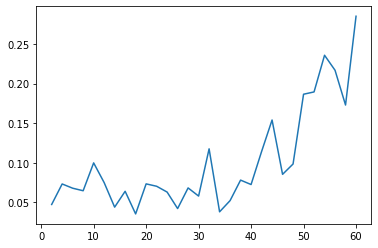

In [ ]:
val_dice = checkpoint["val_dice"]
x = [2 * (i + 1) for i in range(len(checkpoint["val_dice"][0:30]))]
y = checkpoint["val_dice"][0:30]
plt.plot(x,y)
print(val_dice[20:30])

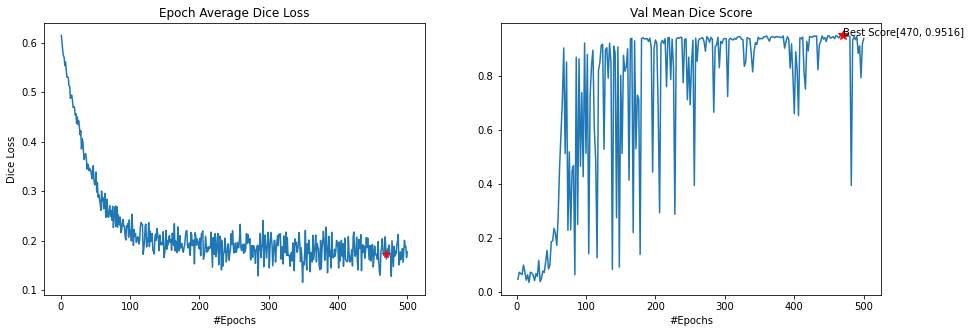

In [ ]:
val_interval = 2
plt.figure("train", (15, 5))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Dice Loss")
x = [i + 1 for i in range(len(checkpoint["train_loss"]))]
y = checkpoint["train_loss"]
plt.xlabel("#Epochs")
plt.ylabel("Dice Loss")
plt.plot(x, y)
plt.plot(checkpoint["best_metric_epoch"], checkpoint["train_loss"][checkpoint["best_metric_epoch"]], 'r*', markersize=8)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice Score")
x = [val_interval * (i + 1) for i in range(len(checkpoint["val_dice"]))]
y = checkpoint["val_dice"]
plt.xlabel("#Epochs")
plt.plot(x, y)
plt.plot(checkpoint["best_metric_epoch"], checkpoint["val_dice"][checkpoint["best_metric_epoch"]//2], 'r*', markersize=10)
plt.annotate("Best Score[470, 0.9516]", xy=(checkpoint["best_metric_epoch"], checkpoint["val_dice"][checkpoint["best_metric_epoch"]//2]))
plt.savefig("LearningCurves.png")
plt.show()

In [ ]:
checkpoint["best_metric_epoch"]

470

# Check best model output with the input image and label

This loads the trained U-Net model with the best performance checkpoint, applies it to a few validation samples using sliding window inference, and displays a side-by-side comparison of the input image, ground truth label, and model's segmentation output for a specific slice.

In [ ]:
import time

In [ ]:
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


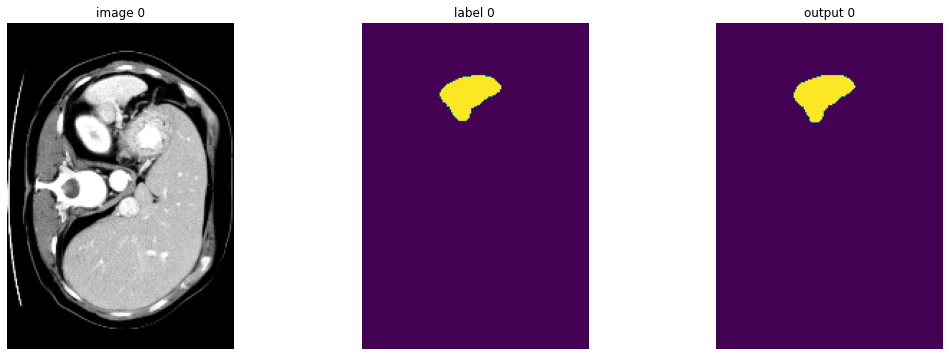

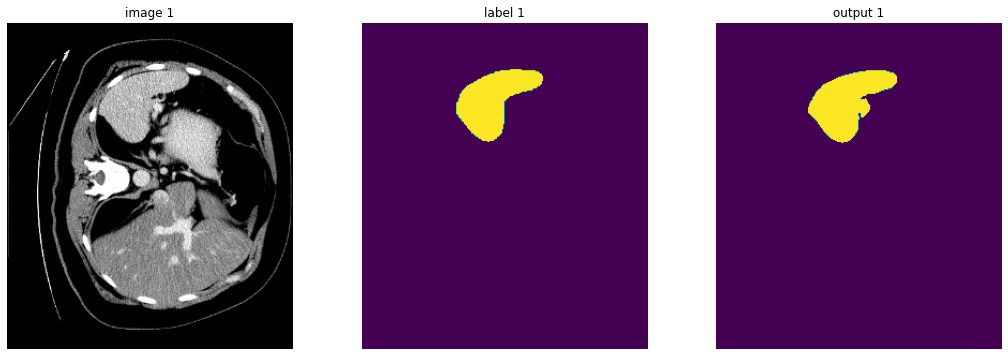

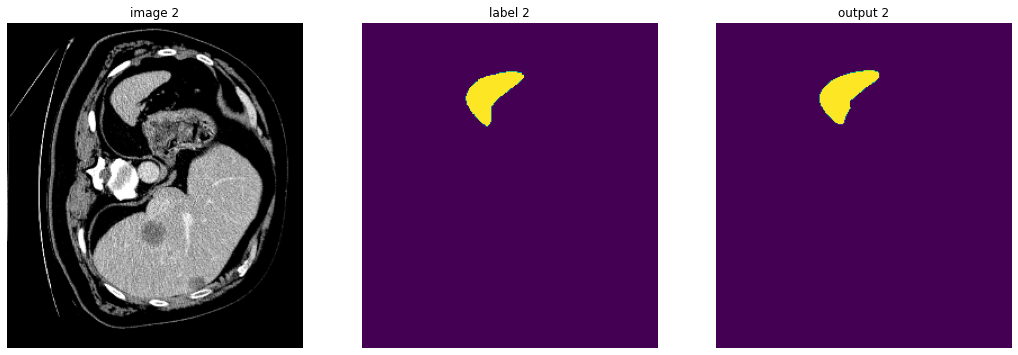

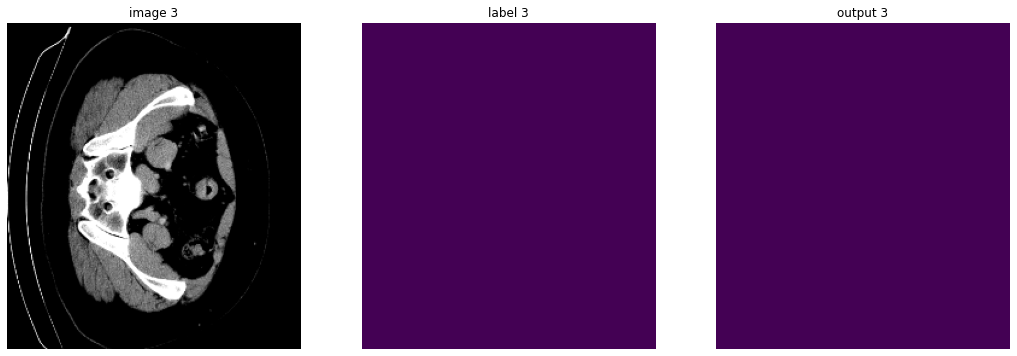

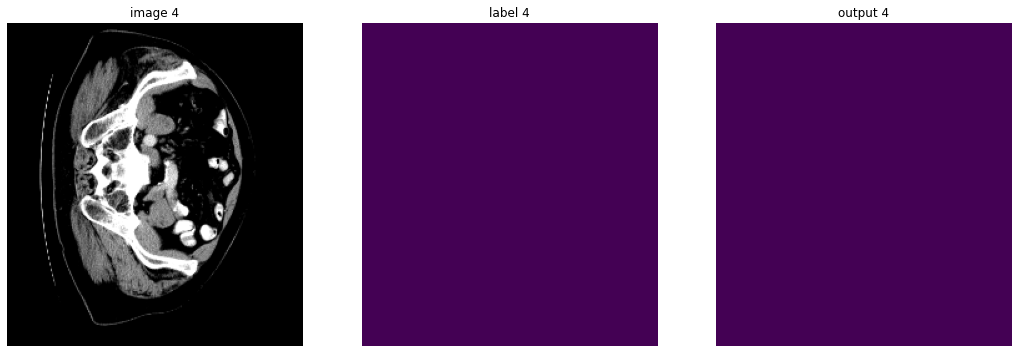

In [ ]:
save_dir = "/content/drive/Spleen-Segmentation/ImprovedResults/"

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

model.load_state_dict(torch.load(
    os.path.join(save_dir, "best_metric_model.pth"), map_location=device))
model.eval()
# elapsed_time = 0
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        # t = time.time()
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # elapsed_time += time.time() - t
        # print("Elapse Time : ", time.time()-t)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.axis("off")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.axis("off")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 4:
            break

# Creating Animation by Overlaying Mask Over Image

This generates a video animation that combines input images, ground truth labels, and model predictions for a single volume slice, creating a dynamic visualization of the segmentation process.

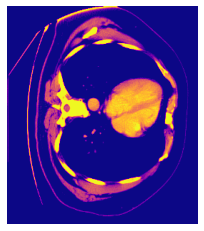

In [ ]:
import matplotlib.pyplot as plt
# import matplotlib.cm as cm
import matplotlib.animation as animation

img = [] # some array of images
frames = [] # for storing the generated images

roi_size = (160, 160, 160)
sw_batch_size = 4
for i, data in enumerate(val_loader):
  val_data = data
  if i == 1:
    break
# val_data = first(val_loader)
val_outputs = sliding_window_inference(
    val_data["image"].to(device), roi_size, sw_batch_size, model
)
outputs = torch.argmax(val_outputs, dim=1)
fig = plt.figure()
plt.axis("off")
for i in range(val_data["image"].shape[-1]):
    frames.append([plt.imshow(val_data["image"][0,0,:,:,i]+(1.5*val_data["label"][0,0,:,:,i])+(1.5*outputs[0,:,:,i]), cmap="plasma",animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True,
                                repeat_delay=2000)
ani.save('movie.mp4')
plt.show()